In [1]:
###########LOAD LIBRARIES###############
#########PUBLIC LIBRARIES#############
import torch                                         
import os                                            
import cv2
import argparse                                           
import torch.nn as nn                                
import random                                        
import torch.nn.functional as F                      
import torchvision.datasets as dset                  
import torchvision.transforms as transforms           
import torchvision.utils as utils                    
import numpy as np
import pickle                                   
from torch.autograd import Variable                  
from torch import optim                              
from torch.utils.data import Dataset, DataLoader
from PIL import Image
#########OUR FUNCTIONS###############
from Process_Label import color_to_classes

In [2]:
#########DATASET CLASS##################
class BodyPoseSet(Dataset):
    """Body pose dataset"""
    def __init__(self, root_dir='./', mode='train', img_transform=None, label_transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.all_imgs, self.all_labels = self.parse_files()
        self.img_transform = img_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_name = self.all_imgs[idx]
        img_path = os.path.join(self.root_dir, img_name)
        label_name= self.all_labels[idx]
        label_path = os.path.join(self.root_dir, label_name)
        img = Image.open(img_path).convert('L')
        label = Image.open(label_path)
        label = torch.LongTensor(color_to_classes(label))

        
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.label_transform is not None:
            label = self.label_transform(label)
            
        sample = {'img':img, 'label':label}

        return sample

    def parse_files(self):
        all_imgs = []
        all_labels = []
        for a in ['easy-pose']:
            for b in [i+1 for i in range(35)]:
                #if b == 36 or b == 106 or b == 178 or b == 72:
                    #continue
                for c in ['Cam1','Cam2','Cam3']:
                    for d in ["{0:04}".format(i+1) for i in range(1001)]:
                        img_name = "%s/%s/%d/images/depthRender/%s/mayaProject.00%s.png" %(a,self.mode,b,c,d)
                        all_imgs.append(img_name)
                        label_name = "%s/%s/%d/images/groundtruth/%s/mayaProject.00%s.png" %(a,self.mode,b,c,d)
                        all_labels.append(label_name)
        return all_imgs, all_labels

In [3]:
#########NET WORK STRUCTURE###########
class Body_Net(nn.Module):
    def __init__(self):
        super(Body_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1)
        self.relu3 = nn.ReLU()
        self.conv4_class = nn.Conv2d(256, 44, kernel_size=3, stride=1)
        self.upscore1 = nn.ConvTranspose2d(44, 44, kernel_size=3, stride=1, bias=False)
        self.score_pool2 = nn.Conv2d(128, 44, kernel_size=1, stride=1)
        self.dropout = nn.Dropout2d()  # defualt = 0.5, which is used in paper
        self.upscore2 = nn.ConvTranspose2d(44, 44, kernel_size=4, stride=2, bias=False)
        self.score_pool1 = nn.Conv2d(64, 44, kernel_size=1, stride=1)
        self.upscore3 = nn.ConvTranspose2d(44, 44, kernel_size=19, stride=7, bias=False)
        self.prob = nn.LogSoftmax(dim=1)

    def forward(self, data):
        h = data
        h = self.relu1(self.conv1(h))
        h = self.pool1(h)
        # record pool 1
        pool1 = h
        h = self.relu2(self.conv2(h))
        h = self.pool2(h)
        # record pool 2
        pool2 = h
        h = self.relu3(self.conv3(h))
        h = self.conv4_class(h)
        h = self.upscore1(h)
        # upsample output
        upscore1 = h
        # crop pool2 and fuse with upscore1
        h =  self.score_pool2(pool2)
        h = h[:, :, 1:17, 1:17]
        score_pool2 = h
        h = upscore1 + score_pool2
        h = self.dropout(h)
        # upsample output
        h = self.upscore2(h)
        upscore2 = h
        # crop pool1 and fuse with upscore2
        h = self.score_pool1(pool1)
        h = h[:, :, 3:37, 3:37]
        score_pool1 = h
        h = upscore2 + score_pool1
        h = self.dropout(h)
        output = self.upscore3(h)
        # compute cross entropy 
        output = self.prob(output)
        return output

In [4]:
weights_dir = "./params_NLLLoss2d.pth.tar"

# Setting up configuration
configs = {"batch_train": 16, \
            "batch_test": 4, \
            "epochs": 2, \
            "num_workers": 4, \
            "learning_rate": 1e-6, \
            "data_augment": True}

# Training process setup
img_trans = transforms.Compose([transforms.Resize((250,250)),transforms.ToTensor()])
label_trans = transforms.Compose([])
body_train = BodyPoseSet(img_transform=img_trans, label_transform = label_trans)
train_loader = DataLoader(body_train, batch_size=configs['batch_train'], shuffle=True, num_workers=configs['num_workers'])

# Training the net
net = Body_Net().cuda()
net.eval()
optimizer = optim.Adam(net.parameters(), lr = configs['learning_rate'])
total_epoch = configs['epochs']
counter = []
loss_history = []
iteration = 0 
#    loss_fn = Cross_Entropy_Loss()
loss_fn = nn.NLLLoss2d()

In [5]:
for batch_idx, batch_sample in enumerate(train_loader):
    img = batch_sample['img']
    label = batch_sample['label'].long()
    img1, y = Variable(img).cuda(), Variable(label).cuda()
    y_pred = net(img1)
    loss = loss_fn(y_pred, y)
    if batch_idx == 1:
        break

In [8]:
np_y = y.data.cpu().numpy()
print np.unique(np_y[0])

[ 0  1  3  5  6  7  8 10 14 15 17 19 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 37 38 40 42]


In [12]:
from matplotlib import pyplot as plt

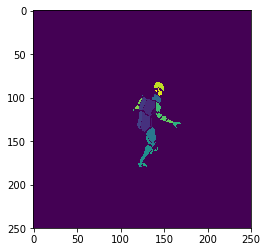

In [13]:
np_y_single =np_y[0]
plt.imshow(np_y_single)
plt.show()

In [10]:
np_ypred = y_pred.data.cpu().numpy()
print np_ypred.shape

(16, 44, 250, 250)


In [11]:
# print np_ypred[0]
single_ypred = np_ypred[0]

layer_distr_y = []
for i in range(44):
    layer_distr_y.append([])
# print len(layer_distr_y)
for i in range(250):
    for j in range(250):
        layer = np.argmax(single_ypred[:,i,j])
        layer_distr_y[layer].append([i,j])

for i in range(44):
    print len(layer_distr_y[i])

pred_img = np.zeros([250,250])
for i in range(44):
    for j in range(len(layer_distr_y[i])):
        x,y = layer_distr_y[i][j]
        pred_img[x,y] = i

2295
284
1442
1941
1073
205
2537
2010
1451
170
2552
1986
598
4779
2583
683
2241
1240
624
1707
1711
764
1752
1158
1507
871
215
1813
748
428
3067
2643
2323
1351
394
1598
1771
1726
1299
224
631
1783
86
236


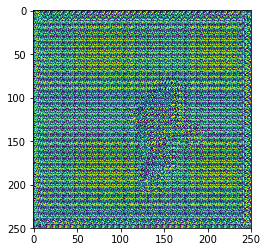

In [14]:
plt.imshow(pred_img)
plt.show()

In [16]:
import pickle
with open("training_history.txt","rb") as fp:
    b = pickle.load(fp)
plt.plot(b[0],b[1])
plt.show()

KeyError: '='